## Free Time-dependent Schrödinger equation

We consider the time-dependent Schrödinger equation for a free particle:

$$
i \partial_t u(x,y,t) = - \Delta u(x,y,t)
$$

with homogeneous Dirichlet boundary conditions:

$$
u(x,y,t) = 0 \quad \text{on } \partial \Omega, t \geq 0
$$

and initial condition:

$$
u(x,y,0) = u_0(x,y)
$$

where

$$
u_0(x,y) = \sin(\pi x) \sin(\pi y)
$$

The exact solution is:

$$
u_{exact}(x,y,t) = \sin(\pi x) \sin(\pi y) e^{-2 i \pi^2 t}
$$

Proof:

In the following, we will assume $\Omega = [0,1]^2$. We take the ansatz:

$$
u(x,y,t) = \phi(x,y) e^{-i \lambda t}
$$

Substituting this into the Schrödinger equation, we get:

$$
i \partial_t \phi(x,y) e^{-i \lambda t} = - \Delta \phi(x,y) e^{-i \lambda t}
$$

which results in:

$$
\lambda \phi(x,y) = - \Delta \phi(x,y)
$$

The eigenfunctions of the Dirichlet Laplacian on the unit square are the sine functions:

$$
\phi_{n,m}(x,y) = \sin(n \pi x) \sin(m \pi y)
$$

where $n,m \in \mathbb{N}$ and $\lambda_{n,m} = \pi^2 (n^2 + m^2)$. From the initial condition, we know that $n = m = 1$.

Therefore, the exact solution is:

$$
u_{exact}(x,y,t) = \sin(\pi x) \sin(\pi y) e^{-2 i \pi^2 t}
$$

## Variational formulation

Take any $v \in H^1_0(\Omega)$, vanishing on the boundary. Multiplying the free time-dependent Schrödinger equation with $\bar{v}$ and integrating over $\Omega$ by parts, we get:

$$
i \int_{\Omega} (\partial_t u(x,y,t)) \bar{v}(x,y,t) = \int_{\Omega} \nabla u(x,y,t) \cdot \nabla \bar{v}(x,y,t).
$$

## Time discretization

Discretizing the time domain $t \in [0,T]$ into $N$ subintervals of length $dt = T/N$, and using an implicit time discretization, we can rewrite the time derivative as:

$$
\partial_t u(x,y,t) \approx \frac{u(x,y,t+dt) - u(x,y,t)}{dt}
$$

Substituting this into the variational formulation, we get:

$$
i \int_{\Omega} \frac{u(x,y,t+dt) - u(x,y,t)}{dt} \bar{v}(x,y) = \int_{\Omega} \nabla u(x,y,t+dt) \cdot \nabla \bar{v}(x,y),
$$

## Sesquilinear form

By rewritting the time-discretized variational formulation as 

$$
i \int_{\Omega} u(x,y,t+dt) \bar{v}(x,y) - dt \int_{\Omega} \nabla u(x,y,t+dt) \cdot \nabla \bar{v}(x,y) = i \int_{\Omega} u(x,y,t) \bar{v}(x,y),
$$

we can identify the sesquilinear form:

$$
a(u,v) = i \int_{\Omega} u(x,y,t+dt) \bar{v}(x,y) - dt \int_{\Omega} \nabla u(x,y,t+dt) \cdot \nabla \bar{v}(x,y)
$$

and the linear form:

$$
L(v) = i \int_{\Omega} u(x,y,t) \bar{v}(x,y).
$$

In [1]:
import dolfinx
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpi4py import MPI
import ufl
from petsc4py import PETSc
from dolfinx.fem.petsc import assemble_vector, assemble_matrix
import pyvista
import tqdm


In [2]:
# Verify that PETSc is using complex numbers
print(f"PETSc ScalarType: {PETSc.ScalarType}")
assert np.dtype(PETSc.ScalarType).kind == 'c', "PETSc must be compiled with complex numbers"

PETSc ScalarType: <class 'numpy.complex128'>


In [3]:
# Time parameters
T = 1.0
N = 100
dt = T/N

In [4]:
# Mesh parameters
nx, ny = 50, 50  # Mesh resolution

# Create mesh
mesh = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, nx, ny)

# Define spatial coordinate
x = ufl.SpatialCoordinate(mesh)

In [5]:
# Define function spaces
V = dolfinx.fem.functionspace(mesh, ("Lagrange", 1))

# Define trial and test functions
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

# Define functions for current and previous time steps
u_t = dolfinx.fem.Function(V, dtype=np.complex128)  # Previous time step
u_t1 = dolfinx.fem.Function(V, dtype=np.complex128)  # Current time step

# Define initial condition
def initial_condition(x):
    return np.sin(np.pi * x[0]) * np.sin(np.pi * x[1])

# Set initial condition (t=0)
u_t.interpolate(initial_condition)

# Define exact solution
def exact_solution(x, t):
    return np.sin(np.pi * x[0]) * np.sin(np.pi * x[1]) * np.exp(-2j * np.pi**2 * t)

In [6]:
# Define sesquilinear form
a = 1j * ufl.inner(u, v) * ufl.dx - dt * ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx

# Linear form
L = 1j * ufl.inner(u_t, v) * ufl.dx

In [7]:
# Get boundary facets and dofs
mesh.topology.create_connectivity(mesh.topology.dim-1, mesh.topology.dim)
boundary_facets = dolfinx.mesh.exterior_facet_indices(mesh.topology)
boundary_dofs = dolfinx.fem.locate_dofs_topological(V, mesh.topology.dim-1, boundary_facets)

# Define boundary conditions
u_D = dolfinx.fem.Function(V, dtype=np.complex128)
u_D.x.array[:] = 0.0
bc = dolfinx.fem.dirichletbc(u_D, boundary_dofs)

In [8]:
# Define linear problem
problem = dolfinx.fem.petsc.LinearProblem(a, L, bcs=[bc])

In [9]:
times = []
l2_errors = []

# Time stepping loop
print("Starting time stepping...")
for n in range(N):
    # Current time
    t = (n + 1) * dt
    times.append(t)

    # Solve for current time step
    u_t1 = problem.solve()

    # Compute exact solution at current time
    u_exact = dolfinx.fem.Function(V, dtype=np.complex128)
    u_exact.interpolate(lambda x: exact_solution(x, t))

    # Compute and store L2 error
    error_form = ufl.inner(u_t1 - u_exact, u_t1 - u_exact) * ufl.dx
    error_local = dolfinx.fem.assemble_scalar(dolfinx.fem.form(error_form))
    error_global = np.sqrt(mesh.comm.allreduce(error_local, op=MPI.SUM))
    l2_errors.append(abs(error_global))

    # Update solution for next time step
    u_t.x.array[:] = u_t1.x.array[:]

    # Print progress
    if (n + 1) % 10 == 0:
        print(f"Time step {n+1}/{N}, t={t:.3f}, L2 error: {abs(error_global):.2e}")

print(f"Time stepping completed. Final L2 error: {l2_errors[-1]:.2e}")

Starting time stepping...
Time step 10/100, t=0.100, L2 error: 8.77e-02
Time step 20/100, t=0.200, L2 error: 1.60e-01
Time step 30/100, t=0.300, L2 error: 2.20e-01
Time step 40/100, t=0.400, L2 error: 2.69e-01
Time step 50/100, t=0.500, L2 error: 3.10e-01
Time step 60/100, t=0.600, L2 error: 3.44e-01
Time step 70/100, t=0.700, L2 error: 3.71e-01
Time step 80/100, t=0.800, L2 error: 3.94e-01
Time step 90/100, t=0.900, L2 error: 4.13e-01
Time step 100/100, t=1.000, L2 error: 4.28e-01
Time stepping completed. Final L2 error: 4.28e-01


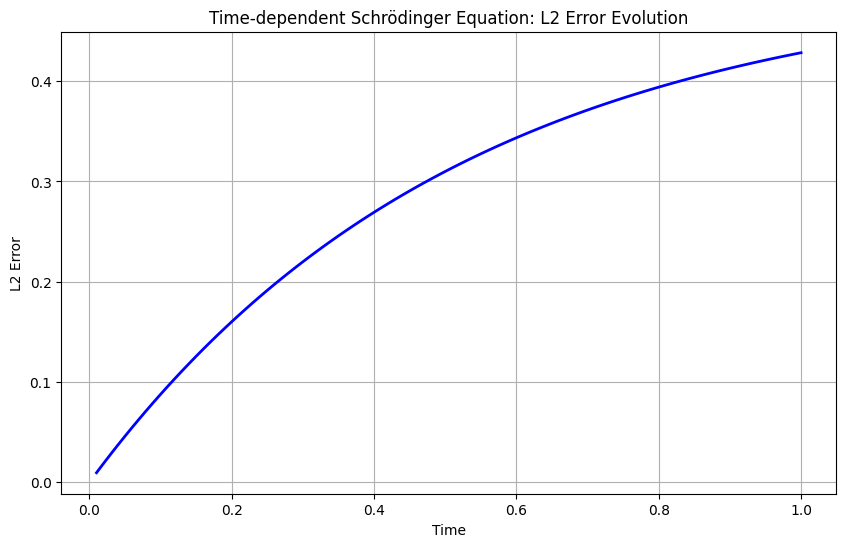

In [10]:
# Plot error evolution
plt.figure(figsize=(10, 6))
plt.plot(times, l2_errors, 'b-', linewidth=2)
plt.xlabel('Time')
plt.ylabel('L2 Error')
plt.title('Time-dependent Schrödinger Equation: L2 Error Evolution')
plt.grid(True)
plt.savefig('schroedinger_error.png', dpi=150, bbox_inches='tight')
plt.show()

In [11]:
# Compare final solution with exact solution
t_final = T
u_exact_final = dolfinx.fem.Function(V, dtype=np.complex128)
u_exact_final.interpolate(lambda x: exact_solution(x, t_final))

In [12]:
print(f"\nFinal time t={t_final}")
print(f"Max error (real part): {np.max(np.abs(u_t1.x.array.real - u_exact_final.x.array.real)):.2e}")
print(f"Max error (imag part): {np.max(np.abs(u_t1.x.array.imag - u_exact_final.x.array.imag)):.2e}")


Final time t=1.0
Max error (real part): 5.13e-01
Max error (imag part): 6.87e-01



Creating visualization...


error: XDG_RUNTIME_DIR is invalid or not set in the environment.
error: XDG_RUNTIME_DIR is invalid or not set in the environment.


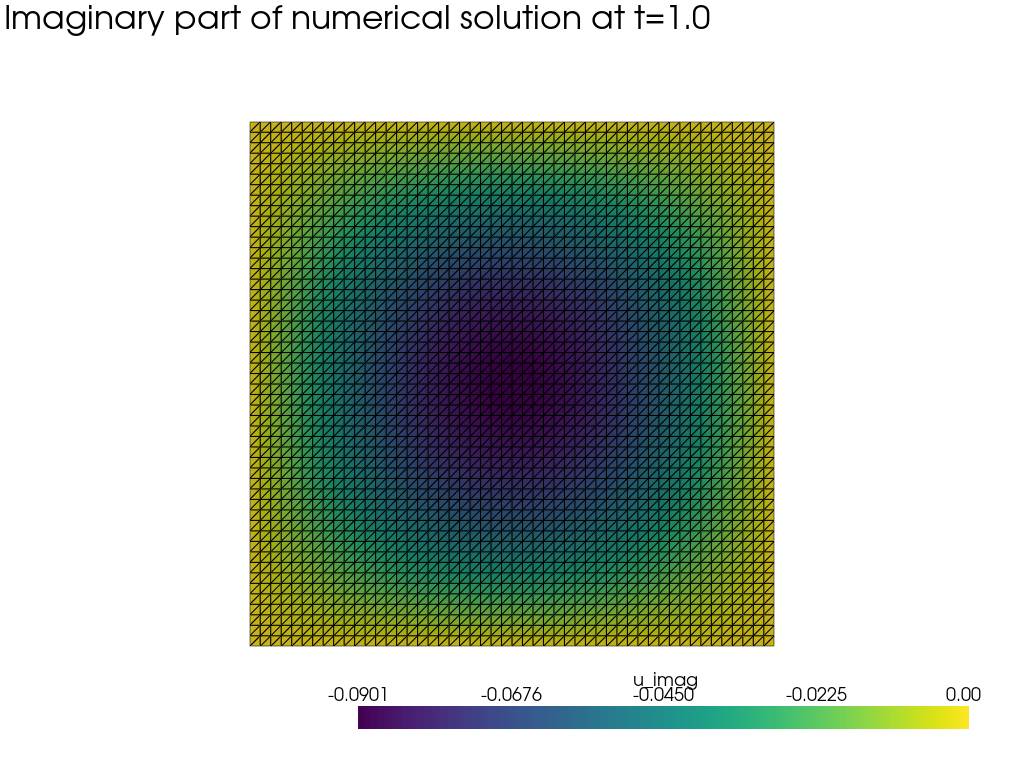

error: XDG_RUNTIME_DIR is invalid or not set in the environment.


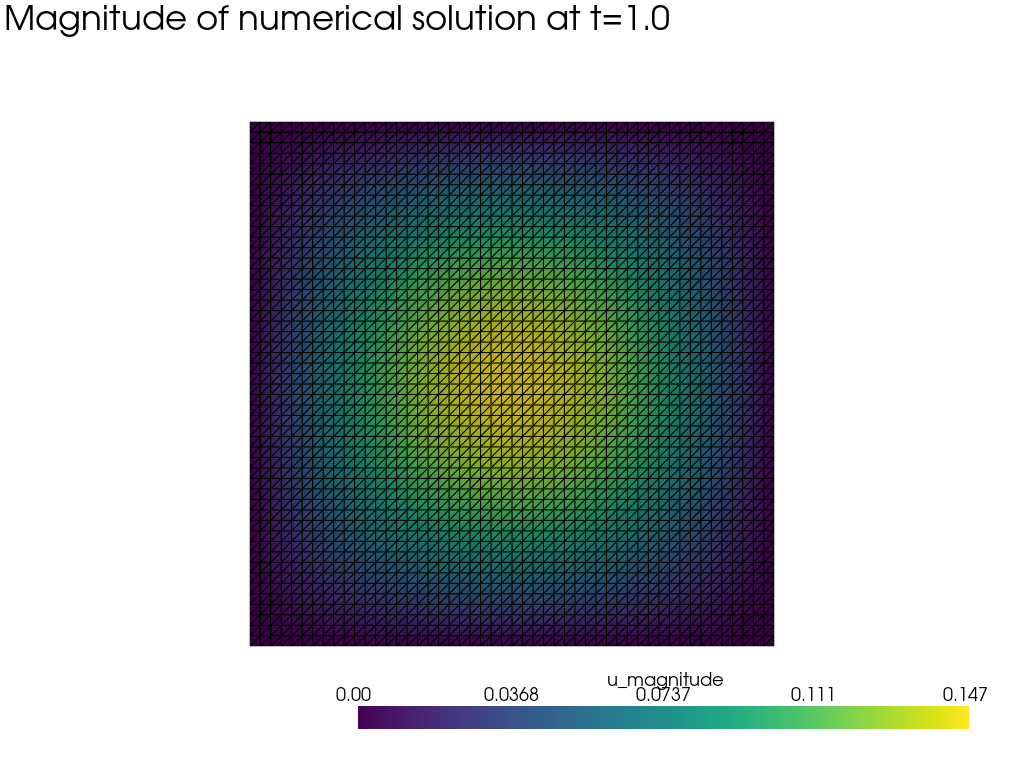

Visualization completed successfully


In [13]:
# Visualization using PyVista
if MPI.COMM_WORLD.rank == 0:
    print("\nCreating visualization...")
    
    try:
        pyvista.start_xvfb()
        
        # Create PyVista mesh
        mesh.topology.create_connectivity(mesh.topology.dim, mesh.topology.dim)
        pyvista_cells, cell_types, geometry = dolfinx.plot.vtk_mesh(V)
        grid = pyvista.UnstructuredGrid(pyvista_cells, cell_types, geometry)
        
        # Add solution data
        grid.point_data["u_real"] = u_t1.x.array.real
        grid.point_data["u_imag"] = u_t1.x.array.imag
        grid.point_data["u_magnitude"] = np.abs(u_t1.x.array)
        
        # Add exact solution data
        grid.point_data["u_exact_real"] = u_exact_final.x.array.real
        grid.point_data["u_exact_imag"] = u_exact_final.x.array.imag
        grid.point_data["u_exact_magnitude"] = np.abs(u_exact_final.x.array)
        
        # Plot real part of numerical solution
        grid.set_active_scalars("u_real")
        p_real = pyvista.Plotter()
        p_real.add_mesh(grid, show_edges=True)
        p_real.view_xy()
        p_real.add_text(f"Real part of numerical solution at t={t_final}", position='upper_left')
        if not pyvista.OFF_SCREEN:
            p_real.show(jupyter_backend='none')
            figure = p_real.screenshot("schroedinger_real.png")
        
        # Plot imaginary part of numerical solution
        grid.set_active_scalars("u_imag")
        p_imag = pyvista.Plotter()
        p_imag.add_mesh(grid, show_edges=True)
        p_imag.view_xy()
        p_imag.add_text(f"Imaginary part of numerical solution at t={t_final}", position='upper_left')
        if not pyvista.OFF_SCREEN:
            p_imag.show()
            figure = p_imag.screenshot("schroedinger_imag.png")
        
        # Plot magnitude
        grid.set_active_scalars("u_magnitude")
        p_mag = pyvista.Plotter()
        p_mag.add_mesh(grid, show_edges=True)
        p_mag.view_xy()
        p_mag.add_text(f"Magnitude of numerical solution at t={t_final}", position='upper_left')
        if not pyvista.OFF_SCREEN:
            p_mag.show()
            figure = p_mag.screenshot("schroedinger_mag.png")
        print("Visualization completed successfully")
        
    except Exception as e:
        print(f"Visualization error: {e}")
        print("This is normal in containerized environments")


Starting grid spacing convergence study...
Solving for grid resolution 8x8...


100%|██████████| 10000/10000 [00:03<00:00, 2850.06it/s]


Final error for nx=8: 3.60826331e-01
Solving for grid resolution 16x16...


100%|██████████| 10000/10000 [00:04<00:00, 2150.28it/s]


Final error for nx=16: 9.41094567e-02
Solving for grid resolution 32x32...


100%|██████████| 10000/10000 [00:09<00:00, 1103.09it/s]


Final error for nx=32: 2.54225354e-02
Solving for grid resolution 64x64...


100%|██████████| 10000/10000 [00:25<00:00, 394.20it/s]


Final error for nx=64: 1.13012865e-02
Solving for grid resolution 128x128...


100%|██████████| 10000/10000 [01:36<00:00, 103.83it/s]


Final error for nx=128: 9.75761904e-03
Solving for grid resolution 256x256...


100%|██████████| 10000/10000 [06:39<00:00, 25.02it/s]


Final error for nx=256: 9.65581152e-03


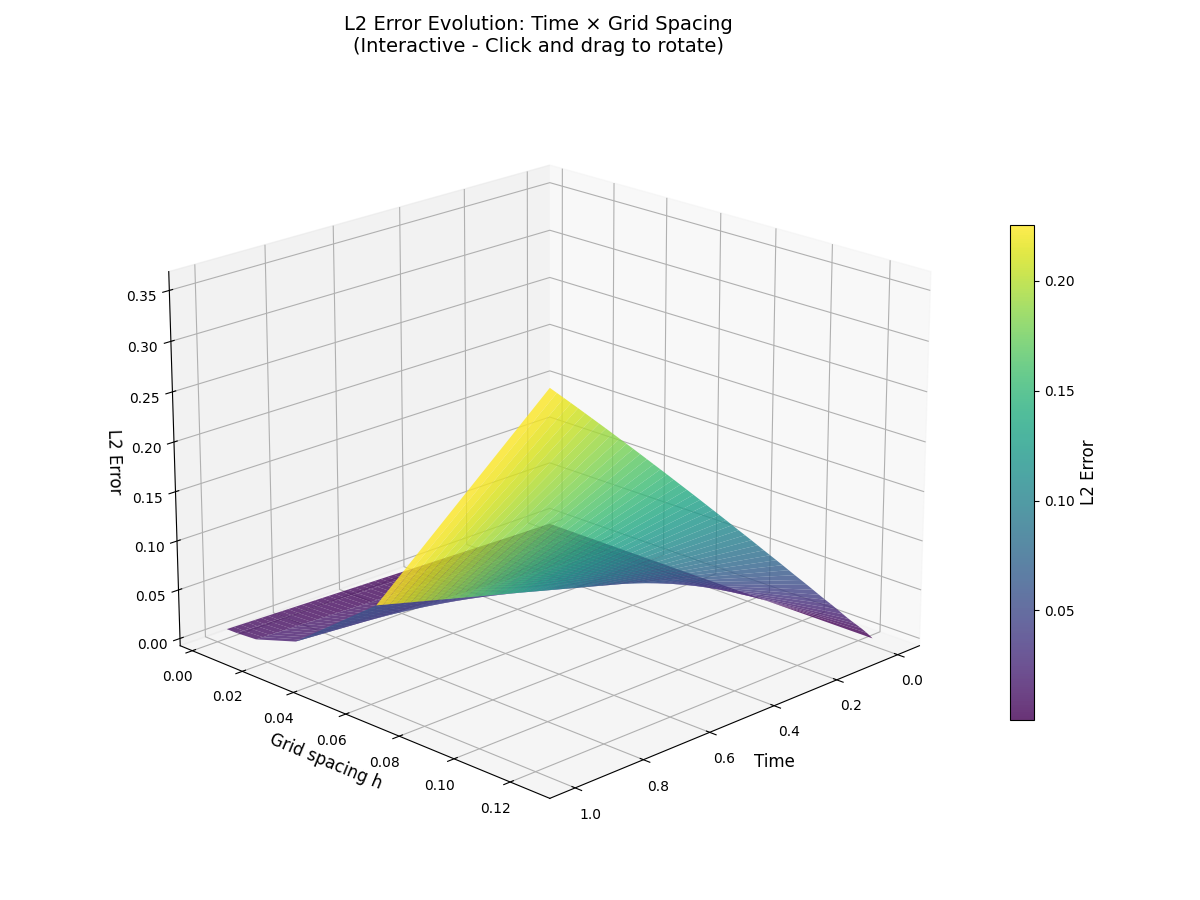


GRID SPACING CONVERGENCE STUDY SUMMARY
Time interval: [0, 1.0]
Time steps: 10000
Grid resolutions: [8, 16, 32, 64, 128, 256]

Final errors:
  nx =   8, h = 0.1250, final error = 3.60826331e-01
  nx =  16, h = 0.0625, final error = 9.41094567e-02
  nx =  32, h = 0.0312, final error = 2.54225354e-02
  nx =  64, h = 0.0156, final error = 1.13012865e-02
  nx = 128, h = 0.0078, final error = 9.75761904e-03
  nx = 256, h = 0.0039, final error = 9.65581152e-03

Observed spatial convergence rate: 1.06
Expected rate for P1 elements: ≈ 2.0


In [14]:
# Grid Spacing Analysis with Interactive 3D Plot
print("Starting grid spacing convergence study...")

# Define different grid resolutions to test
grid_resolutions = [8, 16, 32, 64, 128, 256]  # Reduced for faster computation
T_study = 1.0  # Time interval
N_study = 10000   # Time steps
dt_study = T_study / N_study

# Storage for results
results = {}

for i, nx in enumerate(grid_resolutions):
    print(f"Solving for grid resolution {nx}x{nx}...")
    
    # Create mesh for this resolution
    mesh_study = dolfinx.mesh.create_unit_square(MPI.COMM_WORLD, nx, nx)
    V_study = dolfinx.fem.functionspace(mesh_study, ("Lagrange", 1))
    
    # Define trial and test functions
    u_trial = ufl.TrialFunction(V_study)
    v_test = ufl.TestFunction(V_study)
    u_prev = dolfinx.fem.Function(V_study, dtype=np.complex128)
    
    # Set initial condition
    u_prev.interpolate(initial_condition)
    
    # Define forms
    a_study = 1j * ufl.inner(u_trial, v_test) * ufl.dx - dt_study * ufl.inner(ufl.grad(u_trial), ufl.grad(v_test)) * ufl.dx
    L_study = 1j * ufl.inner(u_prev, v_test) * ufl.dx
    
    # Define boundary conditions
    mesh_study.topology.create_connectivity(mesh_study.topology.dim-1, mesh_study.topology.dim)
    boundary_facets_study = dolfinx.mesh.exterior_facet_indices(mesh_study.topology)
    boundary_dofs_study = dolfinx.fem.locate_dofs_topological(V_study, mesh_study.topology.dim-1, boundary_facets_study)
    
    u_D_study = dolfinx.fem.Function(V_study, dtype=np.complex128)
    u_D_study.x.array[:] = 0.0
    bc_study = dolfinx.fem.dirichletbc(u_D_study, boundary_dofs_study)
    
    # Create linear problem
    problem_study = dolfinx.fem.petsc.LinearProblem(a_study, L_study, bcs=[bc_study])
    
    # Time stepping and error computation
    times_study = []
    l2_errors_study = []
    
    for n in tqdm.tqdm(range(N_study)):
        t = (n + 1) * dt_study
        times_study.append(t)
        
        # Solve
        u_curr = problem_study.solve()
        
        # Compute exact solution
        u_exact_study = dolfinx.fem.Function(V_study, dtype=np.complex128)
        u_exact_study.interpolate(lambda x: exact_solution(x, t))
        
        # Compute L2 error
        error_form = ufl.inner(u_curr - u_exact_study, u_curr - u_exact_study) * ufl.dx
        error_local = dolfinx.fem.assemble_scalar(dolfinx.fem.form(error_form))
        error_global = np.sqrt(mesh_study.comm.allreduce(error_local, op=MPI.SUM))
        l2_errors_study.append(abs(error_global))
        
        # Update for next time step
        u_prev.x.array[:] = u_curr.x.array[:]
    
    # Store results
    results[nx] = {
        'times': np.array(times_study),
        'errors': np.array(l2_errors_study),
        'h': 1.0/nx
    }
    
    print(f"Final error for nx={nx}: {l2_errors_study[-1]:.8e}")

# Create interactive 3D surface plot
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

# Prepare data for 3D plot
Time, H = np.meshgrid(results[grid_resolutions[0]]['times'], 
                      [1.0/nx for nx in grid_resolutions])

Error_surface = np.zeros_like(Time)
for i, nx in enumerate(grid_resolutions):
    Error_surface[i, :] = results[nx]['errors']

# Create interactive 3D plot
fig = plt.figure(figsize=(12, 9))
ax = fig.add_subplot(111, projection='3d')

# Plot surface
surf = ax.plot_surface(Time, H, Error_surface, cmap='viridis', alpha=0.8, 
                       linewidth=0, antialiased=True)

# Customize the plot
ax.set_xlabel('Time', fontsize=12)
ax.set_ylabel('Grid spacing h', fontsize=12)
ax.set_zlabel('L2 Error', fontsize=12)
ax.set_title('L2 Error Evolution: Time × Grid Spacing\n(Interactive - Click and drag to rotate)', fontsize=14)

# Add colorbar
cbar = fig.colorbar(surf, ax=ax, shrink=0.6, aspect=20)
cbar.set_label('L2 Error', fontsize=12)

# Set viewing angle for better initial view
ax.view_init(elev=20, azim=45)

# Add grid lines
ax.grid(True, alpha=0.3)

# Set z axis to log scale
# ax.set_zscale('log')

plt.tight_layout()
plt.savefig('interactive_3d_error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Print summary
print("\n" + "="*50)
print("GRID SPACING CONVERGENCE STUDY SUMMARY")
print("="*50)
print(f"Time interval: [0, {T_study}]")
print(f"Time steps: {N_study}")
print(f"Grid resolutions: {grid_resolutions}")
print("\nFinal errors:")
for nx in grid_resolutions:
    h = 1.0/nx
    final_err = results[nx]['errors'][-1]
    print(f"  nx = {nx:3d}, h = {h:.4f}, final error = {final_err:.8e}")

# Compute convergence rate
grid_spacings = np.array([1.0/nx for nx in grid_resolutions])
final_errors = np.array([results[nx]['errors'][-1] for nx in grid_resolutions])
convergence_rate = np.polyfit(np.log(grid_spacings), np.log(final_errors), 1)[0]
print(f"\nObserved spatial convergence rate: {convergence_rate:.2f}")
print("Expected rate for P1 elements: ≈ 2.0")
print("="*50)


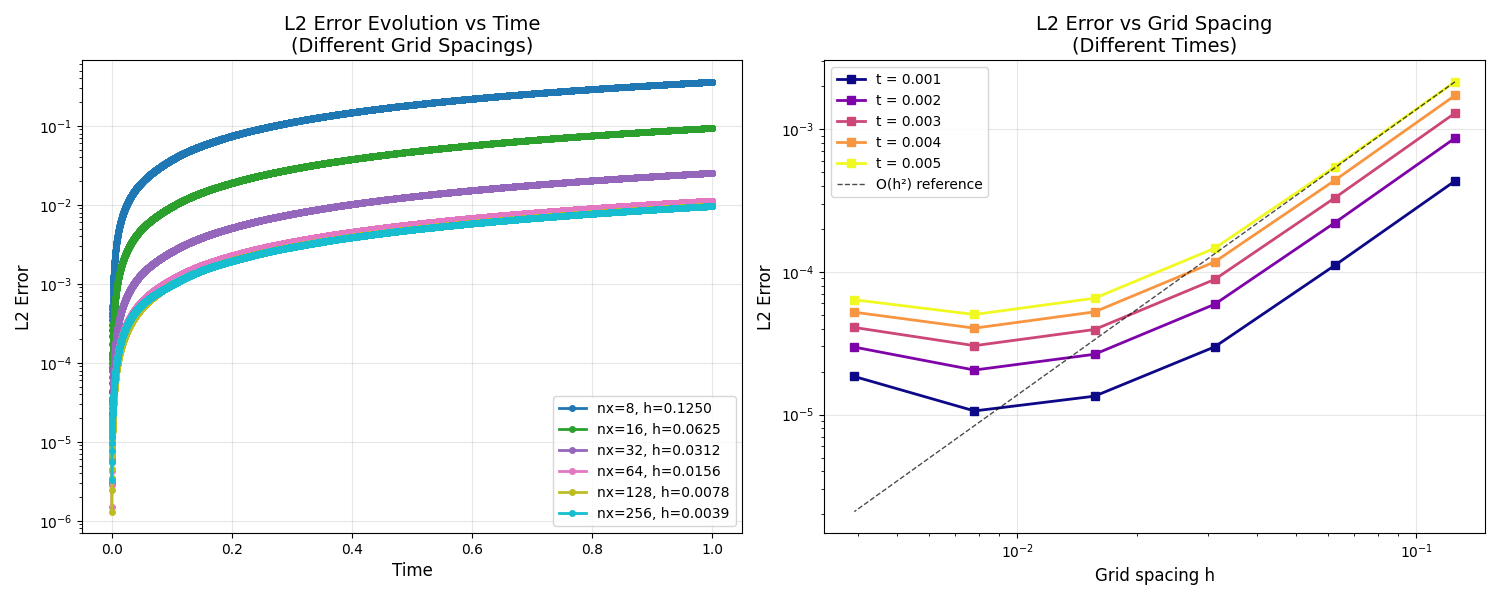


2D ERROR ANALYSIS SUMMARY

Error growth over time:
  nx =   8: 4.33e-05 → 3.61e-01 (×8341.97)
  nx =  16: 1.11e-05 → 9.41e-02 (×8452.07)
  nx =  32: 3.01e-06 → 2.54e-02 (×8443.64)
  nx =  64: 1.49e-06 → 1.13e-02 (×7586.01)
  nx = 128: 1.31e-06 → 9.76e-03 (×7460.25)
  nx = 256: 3.24e-06 → 9.66e-03 (×2979.29)

Spatial convergence at different times:
  t = 0.001: convergence rate = 0.97
  t = 0.002: convergence rate = 1.02
  t = 0.003: convergence rate = 1.04
  t = 0.004: convergence rate = 1.05
  t = 0.005: convergence rate = 1.05


In [15]:
# Two 2D Analysis Plots: Error vs Time and Error vs Grid Spacing
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Plot 1: Error vs Time for different grid spacings
colors = plt.cm.tab10(np.linspace(0, 1, len(grid_resolutions)))

for i, nx in enumerate(grid_resolutions):
    times = results[nx]['times']
    errors = results[nx]['errors']
    ax1.plot(times, errors, color=colors[i], linewidth=2, 
             label=f'nx={nx}, h={1.0/nx:.4f}', marker='o', markersize=4)

ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('L2 Error', fontsize=12)
ax1.set_yscale('log')
ax1.set_title('L2 Error Evolution vs Time\n(Different Grid Spacings)', fontsize=14)
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)

# Plot 2: Error vs Grid Spacing for different times
# Select specific time points for analysis
time_indices = [9, 19, 29, 39, 49]  # Every 10th time step
time_colors = plt.cm.plasma(np.linspace(0, 1, len(time_indices)))

grid_spacings = [1.0/nx for nx in grid_resolutions]

for i, time_idx in enumerate(time_indices):
    errors_at_time = [results[nx]['errors'][time_idx] for nx in grid_resolutions]
    time_value = results[grid_resolutions[0]]['times'][time_idx]
    
    ax2.loglog(grid_spacings, errors_at_time, color=time_colors[i], 
               linewidth=2, marker='s', markersize=6, 
               label=f't = {time_value:.3f}')

# Add reference line for O(h²) convergence
ax2.loglog(grid_spacings, errors_at_time[0] * (np.array(grid_spacings)/grid_spacings[0])**2, 
           'k--', linewidth=1, alpha=0.7, label='O(h²) reference')

ax2.set_xlabel('Grid spacing h', fontsize=12)
ax2.set_ylabel('L2 Error', fontsize=12)
ax2.set_title('L2 Error vs Grid Spacing\n(Different Times)', fontsize=14)
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('2d_error_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

# Print analysis summary
print("\n" + "="*60)
print("2D ERROR ANALYSIS SUMMARY")
print("="*60)

print("\nError growth over time:")
for nx in grid_resolutions:
    initial_error = results[nx]['errors'][0]
    final_error = results[nx]['errors'][-1]
    growth_factor = final_error / initial_error
    print(f"  nx = {nx:3d}: {initial_error:.2e} → {final_error:.2e} (×{growth_factor:.2f})")

print(f"\nSpatial convergence at different times:")
for i, time_idx in enumerate(time_indices):
    time_value = results[grid_resolutions[0]]['times'][time_idx]
    errors_at_time = [results[nx]['errors'][time_idx] for nx in grid_resolutions]
    
    # Compute convergence rate at this time
    log_h = np.log(grid_spacings)
    log_error = np.log(errors_at_time)
    convergence_rate = np.polyfit(log_h, log_error, 1)[0]
    
    print(f"  t = {time_value:.3f}: convergence rate = {convergence_rate:.2f}")

print("="*60)
